In [13]:
import wave
import matplotlib.pyplot as plt
import numpy as np

import scipy as sp
from scipy import signal

import os

from sklearn import metrics
import pandas as pd
import seaborn as sns

In [14]:
def read_actions(path):
    files = os.listdir(path)
    num_files = len(files)
    segment_size = 2000
    data = np.zeros((num_files, segment_size), dtype=np.int16)
    
    for i in range(num_files):
        file = files[i]
        if ".DS_Store" not in file:
            with open(path + "/" +file, "rb") as f:
                signal = [float(line.strip()) for line in f]
                data[i, :] = signal
        else:
            continue        
        
    return data


def wave_data_loader():
    flexion = read_actions('./flexion' + "/action/")
    openhand = read_actions('./openhand' + "/action/")
    punch = read_actions('./punch' + "/action/")
    rest1 = read_actions('./flexion' + "/rest/")
    rest2 = read_actions('./openhand' + "/rest/")
    rest3 = read_actions('./punch' + "/rest/")
    
    all_data = np.vstack((flexion,
                          openhand,
                          punch,
#                           rest1,
                          rest2,
#                           rest3
                         ))
    label = np.hstack(([1]*flexion.shape[0],
                      [2]*openhand.shape[0],
                      [3]*punch.shape[0],
#                       [0]*rest1.shape[0],
                      [0]*rest2.shape[0],
#                       [0]*rest3.shape[0]
                      ))
    label = np.transpose(label)
#     label_multiClass = np.zeros((label.size,4))
#     for i in range(label.size):
#         label_multiClass[i,label[i]] = 1
    return all_data, label


In [325]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

class WaveformDataset(Dataset):
    def __init__(self):
        self.signals, self.labels = wave_data_loader()

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signal = self.signals[idx]
        label = self.labels[idx]
        return signal, label

    
    
class WaveformCNN(nn.Module):
    def __init__(self):
        super(WaveformCNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(in_channels=1, 
                                             out_channels=8, 
                                             kernel_size=7, 
                                             stride=4, 
                                             padding=3),
                                   nn.BatchNorm1d(8),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=5, stride=5),
                                   nn.Dropout(0.3))

        self.conv2 = nn.Sequential(nn.Conv1d(in_channels=8, 
                                             out_channels=16, 
                                             kernel_size=5, 
                                             stride=2, 
                                             padding=2),
                                   nn.BatchNorm1d(16),
                                   nn.ReLU(),
                                   nn.MaxPool1d(kernel_size=2, stride=2),
                                   nn.Dropout(0.3))

        self.fc1 = nn.Sequential(nn.Linear(int(16 * 2000/4/4/5), 16),
                                 nn.Dropout(0.3),
                                 nn.ReLU())
#         
        self.fc2 = nn.Linear(16, 4)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, start_dim=1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x
    
    
def train(model, device, train_loader, optimizer, epoch):
    """
    Trains the specified model for one epoch.
    """
    model.train()
    for batch_idx, data in enumerate(train_loader):
        signal, label = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(signal.float())
#         print(output)
#         print(label)
        loss = nn.CrossEntropyLoss()(output, label)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(signal), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))

            
def test(model, test_loader):
    # Test the model
    correct = 0
    total = 0
    with torch.no_grad():
        model.eval() 
        for signals, labels in test_loader:
            test_output = model(signals.float())
            _, pred_y = torch.max(test_output.data, 1)
#             pred_y = torch.max(test_output, 1)[1].data.squeeze()  # the same function as above
            total += labels.size(0)
            correct += (pred_y == labels).sum().item()
            
    print(f'Accuracy of the CNN on the {total} signals: {100 * correct // total} %')
#     print(correct)
#     print(total)




In [284]:
dataset = WaveformDataset()
train_set, test_set = random_split(dataset, [int(0.8*len(dataset)), int(0.2*len(dataset))+1])
train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
test_loader = DataLoader(test_set, batch_size=10, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WaveformCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)

In [314]:
# train
for epoch in range(1, 10):
    train(model, device, train_loader, optimizer, epoch)

Train Epoch: 1 [0/824 (0%)]	Loss: 0.396867
Train Epoch: 1 [200/824 (24%)]	Loss: 0.699334
Train Epoch: 1 [400/824 (48%)]	Loss: 0.277701
Train Epoch: 1 [600/824 (72%)]	Loss: 0.094909
Train Epoch: 1 [800/824 (96%)]	Loss: 0.983615
Train Epoch: 2 [0/824 (0%)]	Loss: 0.451549
Train Epoch: 2 [200/824 (24%)]	Loss: 0.429126
Train Epoch: 2 [400/824 (48%)]	Loss: 0.580134
Train Epoch: 2 [600/824 (72%)]	Loss: 0.606569
Train Epoch: 2 [800/824 (96%)]	Loss: 0.103049
Train Epoch: 3 [0/824 (0%)]	Loss: 0.270397
Train Epoch: 3 [200/824 (24%)]	Loss: 0.404652
Train Epoch: 3 [400/824 (48%)]	Loss: 0.136831
Train Epoch: 3 [600/824 (72%)]	Loss: 0.289269
Train Epoch: 3 [800/824 (96%)]	Loss: 0.586970
Train Epoch: 4 [0/824 (0%)]	Loss: 1.096336
Train Epoch: 4 [200/824 (24%)]	Loss: 0.380200
Train Epoch: 4 [400/824 (48%)]	Loss: 0.494779
Train Epoch: 4 [600/824 (72%)]	Loss: 0.660867
Train Epoch: 4 [800/824 (96%)]	Loss: 0.382733
Train Epoch: 5 [0/824 (0%)]	Loss: 0.218915
Train Epoch: 5 [200/824 (24%)]	Loss: 0.852923
Tra

In [307]:
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-3)

In [315]:
# test set
test(model,test_loader)

Accuracy of the CNN on the 1031 signals: 93 %


In [316]:
# train set
test(model,train_loader)

Accuracy of the CNN on the 824 signals: 93 %


In [327]:
# confusion matrix
def confusion_matrix(model, test_loader):

    y_true = []
    y_pred = []
    
    with torch.no_grad():
        model.eval() 
        for signals, labels in test_loader:
            outputs = model(signals.float())
            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.cpu().numpy())   
            y_true.extend(labels.cpu().numpy())
    
    cf_matrix = metrics.confusion_matrix(y_true, y_pred)
    
    class_names = ('rest', 'flexion', 'openhand', 'punch')
 
    # Create pandas dataframe
    dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names)
    
    plt.figure(figsize=(8, 6))
    # Create heatmap
    sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d")
    plt.title("Confusion Matrix"), plt.tight_layout()
    plt.ylabel("True Class"), 
    plt.xlabel("Predicted Class")
    plt.show()
    
    print(metrics.classification_report(y_true, y_pred, target_names=class_names))
    
    return cf_matrix

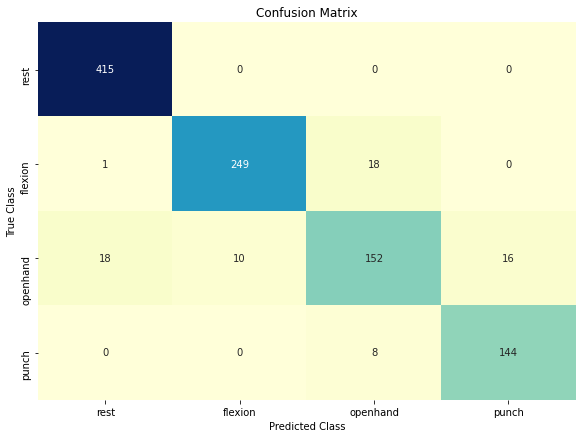

              precision    recall  f1-score   support

        rest       0.96      1.00      0.98       415
     flexion       0.96      0.93      0.94       268
    openhand       0.85      0.78      0.81       196
       punch       0.90      0.95      0.92       152

    accuracy                           0.93      1031
   macro avg       0.92      0.91      0.91      1031
weighted avg       0.93      0.93      0.93      1031



In [328]:
# train_set, test_set = random_split(dataset, [int(0.8*len(dataset)), int(0.2*len(dataset))+1])
# train_loader = DataLoader(train_set, batch_size=10, shuffle=True)
# test_loader = DataLoader(dataset, batch_size=10, shuffle=True)
cm = confusion_matrix(model,test_loader)

In [ ]:
index = 0

sensitivity1 = cm1[0,0]/(cm1[0,0]+cm1[0,1])
print('Sensitivity : ', sensitivity1 )

specificity1 = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print('Specificity : ', specificity1)

In [127]:
# # save parameter
# PATH = r'./model_parameter/dropout10.pth'
# torch.save(model.state_dict(), PATH)

In [324]:
label = dataset.labels
(label==3).sum()

152

In [176]:
# model.load_state_dict(torch.load(r'./model_parameter/dropout10.pth'))

<All keys matched successfully>

In [237]:
# save model
model_path = r'./model_parameter/2-3_with_model.pth'
torch.save(model, model_path)

In [291]:
# read model
model = torch.load(model_path)

In [320]:
len(dataset)

1031